Testing Prophet and SARIMA on the Same Dataset

In this article, I will try to forecast the U.S. consumer price index i.e. average monthly change in the price for goods and services paid by urban consumers between any two time periods. It can also represent the buying habits of urban consumers I will be using Prophet and SARIMA models to accomplish this task. The output from the two models will be compared using R-squared value (correlation strength), root mean squared error (RMSE) and mean absolute error (MAE).

The data and python notebook can be downloaded from my github page.

Importing Data and Libraries

The first step is to import libraries such as fbprophet, statsmodels, sklearn, pandas, numpy, seaborn, matplotlib etc. Please make sure you install these libraries before running the code. To create graphs, we will be using the "bmh" styling.

In [92]:
from fbprophet import Prophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
warnings.filterwarnings("ignore")
plt.style.use('bmh')

Next, we will import the Consumer Price Index for All Urban Consumers from Federal Reserve Bank of St. Louis' website and load that data into a pandas dataframe 'data'.

In [120]:
data = pd.read_csv("CPIAUCSL.csv")
# Check the last 5 elements of the dataframe
data.tail()

,DATE,CPIAUCSL
888,2021-01-01,262.231
889,2021-02-01,263.161
890,2021-03-01,264.793
891,2021-04-01,266.832
892,2021-05-01,268.551


In [121]:
# Check if the the data is set up in proper format and then start modeling/forecasting. 
data.dtypes

DATE         object
CPIAUCSL    float64
dtype: object

The datatype defining the 'DATE' field is an object. Let's convert that into datetime format, a prerequisite of Prophet model.

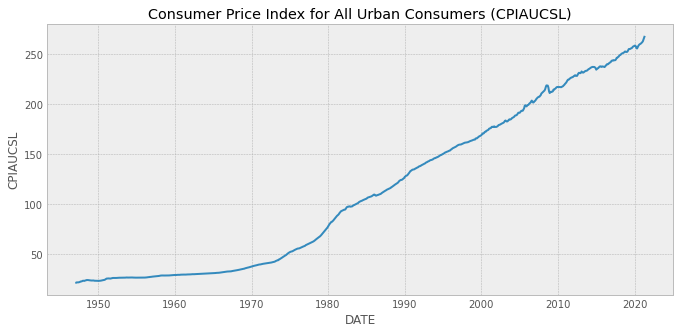

In [122]:
#Convert 'DATE' object to date datatype
data['DATE'] = pd.to_datetime(data['DATE'])
#Visualize the dataframe
plt.figure(figsize=(10,5))
sns.lineplot(data=data, x="DATE", y="CPIAUCSL")
plt.title("Consumer Price Index for All Urban Consumers (CPIAUCSL)")
plt.grid(True)
plt.show()

Prophet expects that the format of the dataframe to be specific. The model expects a ‘ds’ column  that contains the datetime field and and a ‘y’ column that contains the value we are wanting to model/forecast. Therefore, we need to rename the columns accordingly. Next, we define Prophet's parameters to optimize the model's output. 

In [123]:
data.columns = ["ds","y"]
model = Prophet(growth="linear", seasonality_mode="multiplicative", changepoint_prior_scale=30, seasonality_prior_scale=35,
               daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=False
               ).add_seasonality(
                name='monthly',
                period=30.5,
                fourier_order=30)

model.fit(data)

Now its time to start forecasting. With Prophet, we start by building some future time data with the following command:

In [124]:
future = model.make_future_dataframe(periods= 120, freq='m')

In this line of code, we created a pandas dataframe with 120 (periods = 120) future data points with a monthly frequency (freq = ‘m’). In the next line of code, we check the last five dates of the forecasted data.

In [125]:
future.tail()

,ds
1008,2030-12-31
1009,2031-01-31
1010,2031-02-28
1011,2031-03-31
1012,2031-04-30


Now, we will try to predict the actual values using Prophet library and check the last five elements of the forecast.

In [126]:
forecast = model.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,monthly,monthly_lower,monthly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
1008,2030-12-31,303.894468,275.160958,331.036481,274.744819,330.031412,0.002452,0.002452,0.002452,0.002452,0.002452,0.002452,0.0,0.0,0.0,304.639566
1009,2031-01-31,304.246546,275.938092,331.570980,274.772383,330.846433,0.003346,0.003346,0.003346,0.003346,0.003346,0.003346,0.0,0.0,0.0,305.264586
1010,2031-02-28,304.564551,274.892383,331.966620,274.725246,331.329627,0.001559,0.001559,0.001559,0.001559,0.001559,0.001559,0.0,0.0,0.0,305.039324
1011,2031-03-31,304.916629,274.040524,332.203798,274.798627,331.977116,-0.000239,-0.000239,-0.000239,-0.000239,-0.000239,-0.000239,0.0,0.0,0.0,304.843743
1012,2031-04-30,305.257349,275.468755,333.348726,274.869640,332.603622,0.001559,0.001559,0.001559,0.001559,0.001559,0.001559,0.0,0.0,0.0,305.733202


If we take a look at the data using .tail(), we notice there are a bunch of columns in the forecast dataframe. The important ones (for now) are ‘ds’ (datetime), ‘yhat’ (forecast), ‘yhat_lower’ and ‘yhat_upper’ (uncertainty levels).

In [127]:
forecast[["ds","yhat","yhat_lower","yhat_upper"]].head()

,ds,yhat,yhat_lower,yhat_upper
0,1947-01-01,22.346034,21.193692,23.440152
1,1947-02-01,22.479811,21.395886,23.585201
2,1947-03-01,22.600999,21.474538,23.714828
3,1947-04-01,22.603295,21.497293,23.743797
4,1947-05-01,22.683578,21.618404,23.776123


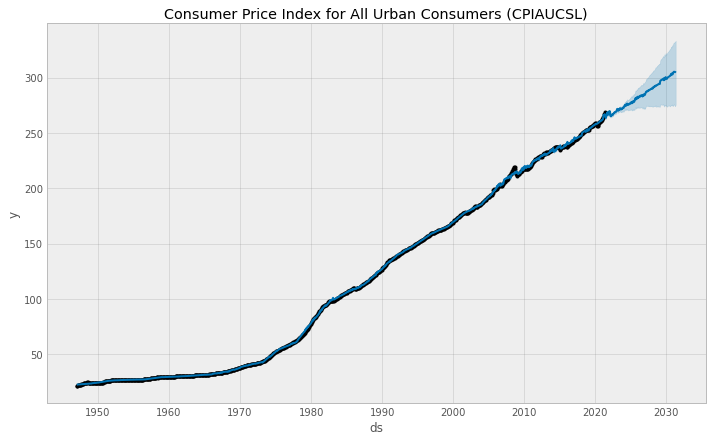

In [128]:
# Plot the graph of this data to get an understanding of how well forecast looks
model.plot(forecast);
plt.title("Consumer Price Index for All Urban Consumers (CPIAUCSL)")
plt.show()

Next, we will check the model robustness using the best metrics for measuring accuracy of this model. Utilizing a combination of R-Squared, Mean Squared Error and Mean Absolute Error will help us to gauge the quality of our model. We will Python's Scikit-Learn library to quickly calculate these metrics.

R-squared (R2) is a statistical measure that represents the proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regression model. 

Mean Absolute Error (MAE) measures the average magnitude of the errors in a set of predictions, without considering their direction. It’s the average over the test sample of the absolute differences between prediction and actual observation where all individual differences have equal weight.

RMSE (Root Mean Squared Error) is the distance, on average, of a data point from the fitted line, measured along a vertical line. The RMSE is directly interpretable in terms of measurement units, and so is a better measure of goodness of fit than a correlation coefficient.

In [129]:
# calculate MAE between expected and predicted values
y_true = data['y'].values
y_pred = forecast['yhat'][:893].values
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)
r = r2_score(y_true, y_pred)
print('R-squared Score: %.3f' % r)
rms = mean_squared_error(y_true, y_pred, squared=False)
print('RMSE: %.3f' % rms)

MAE: 0.518
R-squared Score: 1.000
RMSE: 0.855


For the U.S. CPIAUCSL time-series data, the Prophet model gives an R-squared value of 1.000 i.e. 100% of variance in our data set is explained by the model. The MAE is calculated to be 0.518 i.e. for each data point, the average magnitude error is roughly 0.52% , indicating that our model is robust.

Finally, we create a plot to compare actual vs. predicted values to give a clear understanding of how our model visually looks against the existing U.S. CPIAUCSL dataset.

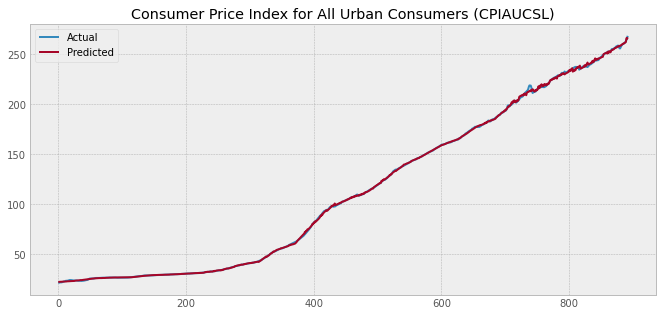

In [130]:
plt.figure(figsize=(10,5))
# plot expected vs actual
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title("Consumer Price Index for All Urban Consumers (CPIAUCSL)")
plt.grid(True)
plt.legend()
plt.show()

SARIMA Model

   Now, let's take a look at how the SARIMA model will perform for the same dataset. The model's notation is SARIMA(p, d, q).(P,D,Q)lag. These three parameters account for seasonality, trend, and noise in data. I tried to calculate the AIC (Akaike information criterion) which is an estimator of the relative quality of statistical models for a given set of data. Given a collection of models for the data, AIC estimates the quality of each model, relative to each of the other models. We need to select the best combination, that delivers the lowest AIC value. The following program will determine the optimal triplet needed to give the best (P,D,Q) combination between 0 and 2. We will use the itertools library for this short piece of code.

In [131]:
data = pd.read_csv('CPIAUCSL.csv')

# Define the p, d and q parameters to take any value between 0 and 3
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
simple_pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(i[0], i[1], i[2], 12) for i in list(itertools.product(p, d, q))]

print('Parameter combinations for Seasonal ARIMA...')

warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in simple_pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(data['CPIAUCSL'],
                                            order=param,
                                            )

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

Parameter combinations for Seasonal ARIMA...
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:11339.186887905873
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:11339.186887905873
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:11339.186887905873
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:11339.186887905873
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:11339.186887905873
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:11339.186887905873
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:11339.186887905873
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:11339.186887905873
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:10112.093980884649
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:10112.093980884649
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:10112.093980884649
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:10112.093980884649
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:10112.093980884649
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:10112.093980884649
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:10112.093980884649
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:10112.093980884649
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1272.31978250997
ARIMA

In [132]:
best_model = SARIMAX(data['CPIAUCSL'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit()
print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                           CPIAUCSL   No. Observations:                  893
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -299.487
Date:                            Wed, 07 Jul 2021   AIC                            608.974
Time:                                    23:14:18   BIC                            632.874
Sample:                                         0   HQIC                           618.114
                                            - 893                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3272      0.035      9.392      0.000       0.259       0.395
ma.L1          0.2808      0.034   

Model Forecast

In the forecast step, we will try to predict the U.S. CPIAUCSL for the next 120 steps i.e. 10 years.

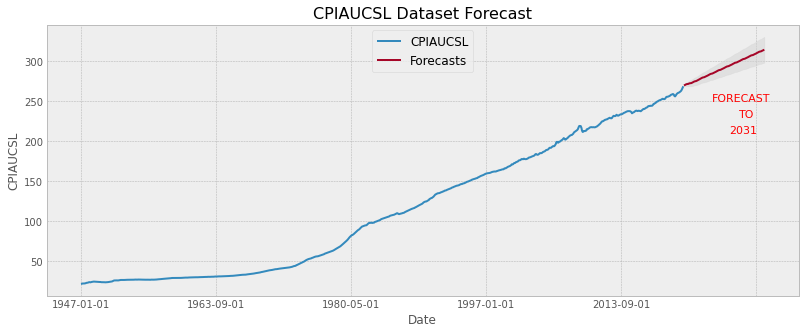

In [133]:
#Forecasting 10 years ahead
forecast_values = best_model.get_forecast(steps = 120)

#Confidence intervals of the forecasted values
forecast_ci = forecast_values.conf_int()

#Plot the data
ax = data.plot(x='DATE' ,y='CPIAUCSL', figsize = (12, 5), legend = True)

#Plot the forecasted values 
forecast_values.predicted_mean.plot(ax=ax, label='Forecasts', figsize = (12, 5), grid=True)

#Plot the confidence intervals
ax.fill_between(forecast_ci.index,
                forecast_ci.iloc[: , 0],
                forecast_ci.iloc[: , 1], color='#D3D3D3', alpha = .5)
plt.title("CPIAUCSL Dataset Forecast", size=16)
plt.ylabel('CPIAUCSL', size=12)
plt.xlabel('Date', size=12)
plt.legend(loc='upper center', prop={'size': 12})
#annotation
ax.text(935, 250, 'FORECAST', fontsize=11,  color='RED')
ax.text(975, 230, 'TO', fontsize=11,  color='RED')
ax.text(960, 210, '2031', fontsize=11,  color='RED')
plt.show()

Validating the Forecast

To evaluate the model performance, we calculate the R-squared score and the root mean square error of my dataset to test the authenticity of the model. The model has 99.8% accuracy, which is pretty good. Mean Absolute Error of the model is 0.35 and is low enough for us to be confident about the model's ability to predict accurately in the future. 

In [135]:
#divide into train and validation set to calculate R-squared score and mean absolute percentage error 
train = data[:int(0.85*(len(data)))]
test = data[int(0.85*(len(data))):]
start=len(train)
end=len(train)+len(test)-1
predictions = best_model.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA Predictions')
evaluation_results = pd.DataFrame({'r2_score': r2_score(test['CPIAUCSL'], predictions)}, index=[0])
evaluation_results['mean_absolute_error'] = mean_absolute_error(test['CPIAUCSL'], predictions)
evaluation_results['root_mean_squared_error'] = np.sqrt(mean_squared_error(test['CPIAUCSL'], predictions))
evaluation_results

,r2_score,mean_absolute_error,root_mean_squared_error
0,0.998569,0.355296,0.479065


Finally, we compare the actual vs. predicted values to get a clear understanding of the effectiveness of our model. 

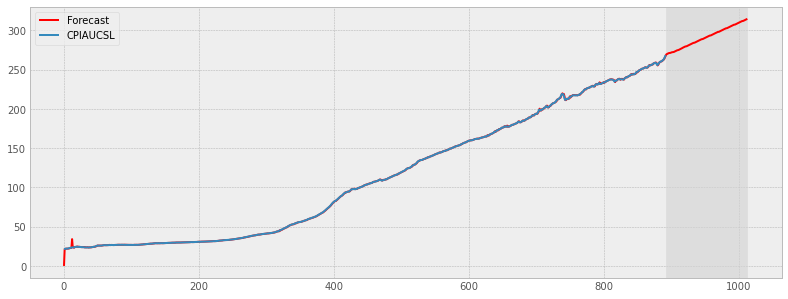

In [136]:
data['sarima_model'] = best_model.fittedvalues
forecast = best_model.predict(start=data.shape[0], end=data.shape[0] + 120)
forecast = data['sarima_model'].append(forecast)
plt.figure(figsize=(12, 5))
plt.plot(forecast, color='r', label='Forecast')
plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.6, color='lightgrey')
plt.plot(data['CPIAUCSL'], label='CPIAUCSL')
plt.legend()
plt.show()